# Algoritmos de Classificação: Regressão Logística

Nós vamos utilizar o dataset Bank Marketing disponibilizado no [site da UCI](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing). Utilizaremos uma versão adaptada para os objetivos da aula e disponível na pasta `data`.

> The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the investment product would be or not subscribed.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, log_loss)

from plotting import (multiple_histograms_plot, bar_plot_with_categorical, 
                      plot_confusion_matrix, plot_roc)

In [3]:
sns.set_context("notebook", font_scale=1.5)

In [4]:
df = pd.read_csv('../data/bank_marketing.csv')

Segue uma descrição sucinta de cada uma das colunas do dataset:

- `duration_seconds`: last contact duration, in seconds (numeric).

- `duration_minutes`: last contact duration, in minutes (numeric).

- `duration_hours`: last contact duration, in hours (numeric).

- `emp.var.rate`: employment variation rate - quarterly indicator (numeric)

- `nr.employed`: number of employees - quarterly indicator (numeric)

- `euribor3m`: euribor 3 month rate - daily indicator (numeric)

- `month`: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

- `contact`: contact communication type (1 for cellular, 2 for telephone) 

- `loan`: has personal loan? (0 for no, 1 for yes)

- `subscribed` - has the client subscribed a term deposit? (True, False)

## Exploratory Data Analysis (EDA)

In [4]:
df.shape

(9280, 10)

In [5]:
df.dtypes

duration_seconds      int64
duration_minutes    float64
duration_hours      float64
emp.var.rate        float64
nr.employed         float64
euribor3m           float64
month                object
contact               int64
loan                  int64
subscribed             bool
dtype: object

In [6]:
df.head()

,duration_seconds,duration_minutes,duration_hours,emp.var.rate,nr.employed,euribor3m,month,contact,loan,subscribed
0,1575,26.250000,0.437500,1.1,5191.0,4.857,may,1,0,True
1,1042,17.366667,0.289444,1.1,5191.0,4.857,may,1,0,True
2,1467,24.450000,0.407500,1.1,5191.0,4.857,may,1,0,True
3,579,9.650000,0.160833,1.1,5191.0,4.857,may,1,0,True
4,461,7.683333,0.128056,1.1,5191.0,4.857,may,1,0,True


In [7]:
null_count = df.isnull().sum().sort_values(ascending=False)
null_percentage = null_count / len(df)
pd.DataFrame(data=[null_count, null_percentage],
             index=['null_amount', 'null_ratio']).T

,null_amount,null_ratio
subscribed,0.0,0.0
loan,0.0,0.0
contact,0.0,0.0
month,0.0,0.0
euribor3m,0.0,0.0
nr.employed,0.0,0.0
emp.var.rate,0.0,0.0
duration_hours,0.0,0.0
duration_minutes,0.0,0.0
duration_seconds,0.0,0.0


In [8]:
no_duration = df['duration_seconds'] == 0
print(f'calls with no duration: {no_duration.sum()}')

calls with no duration: 0


In [9]:
subscribed_mask = df['subscribed'] == True
subscription_rate = (subscribed_mask).sum() / (subscribed_mask.sum() + (~subscribed_mask).sum())
print(f'subscription_rate: {subscription_rate}')

subscription_rate: 0.5


### duration_seconds

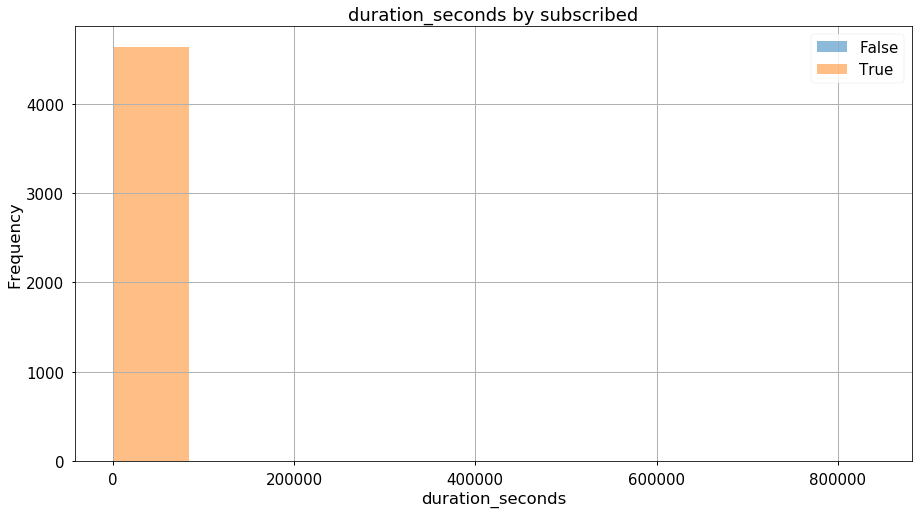

In [10]:
multiple_histograms_plot(df, x='duration_seconds', hue='subscribed')

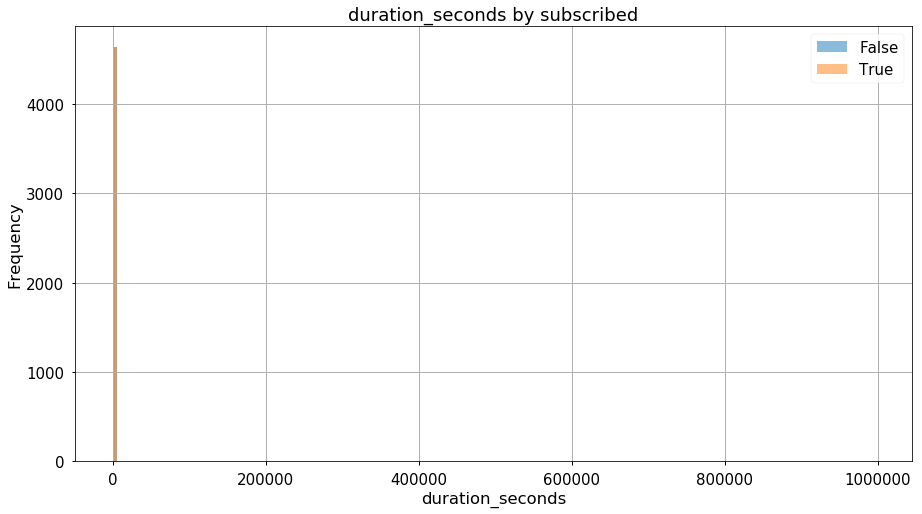

In [11]:
multiple_histograms_plot(df, x='duration_seconds', hue='subscribed',
                         bins=range(0, 1_000_000, 5_000))

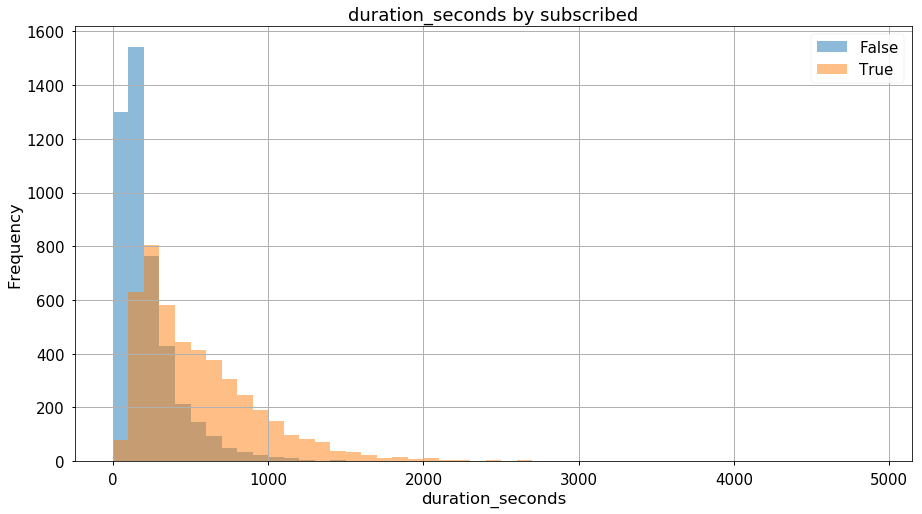

In [12]:
multiple_histograms_plot(df, x='duration_seconds', hue='subscribed',
                         bins=range(0, 5_000, 100))

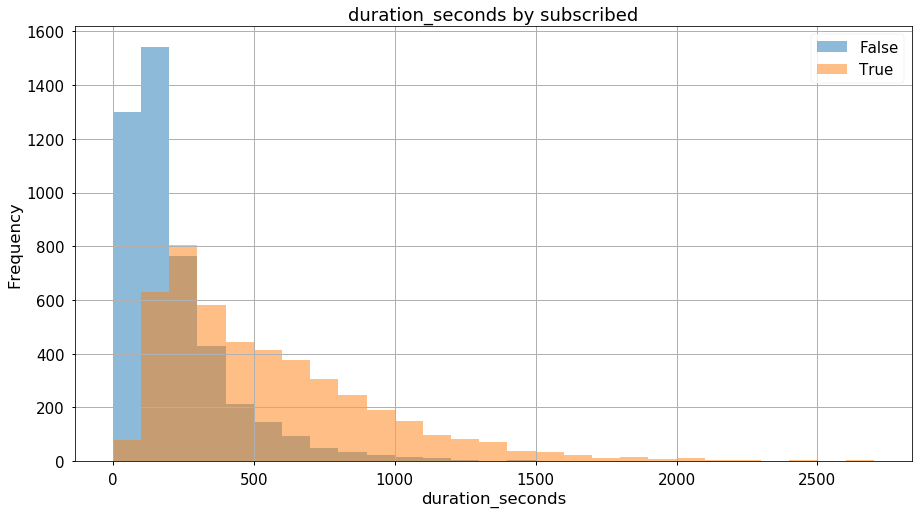

In [13]:
multiple_histograms_plot(df, x='duration_seconds', hue='subscribed',
                         bins=range(0, 2_800, 100))

In [14]:
np.log10(df['duration_seconds'].max())

5.9241758703019212

min = 6.3s
max = 1000000s


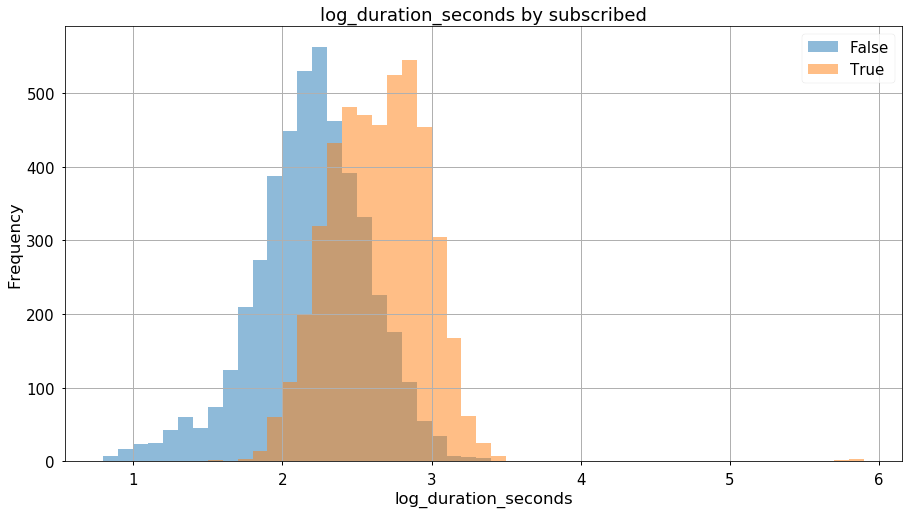

In [15]:
df['log_duration_seconds'] = np.log10(df['duration_seconds'])

min_log_duration_seconds = 0.8
max_log_duration_seconds = 6
print(f'min = {10**min_log_duration_seconds:.1f}s')
print(f'max = {10**max_log_duration_seconds:.0f}s')

multiple_histograms_plot(df, x='log_duration_seconds', hue='subscribed',
                         bins=np.arange(min_log_duration_seconds, 
                                        max_log_duration_seconds, 
                                        0.1))

### emp.var.rate

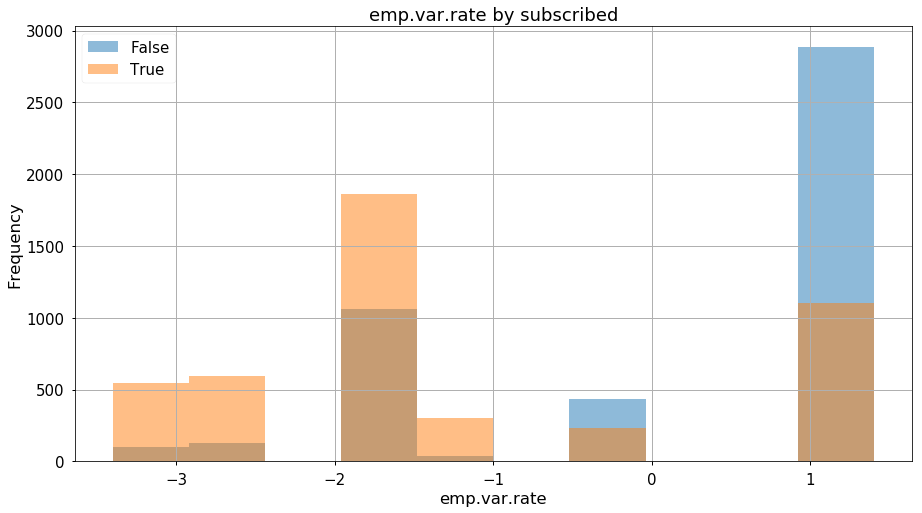

In [16]:
multiple_histograms_plot(df, x='emp.var.rate', hue='subscribed')

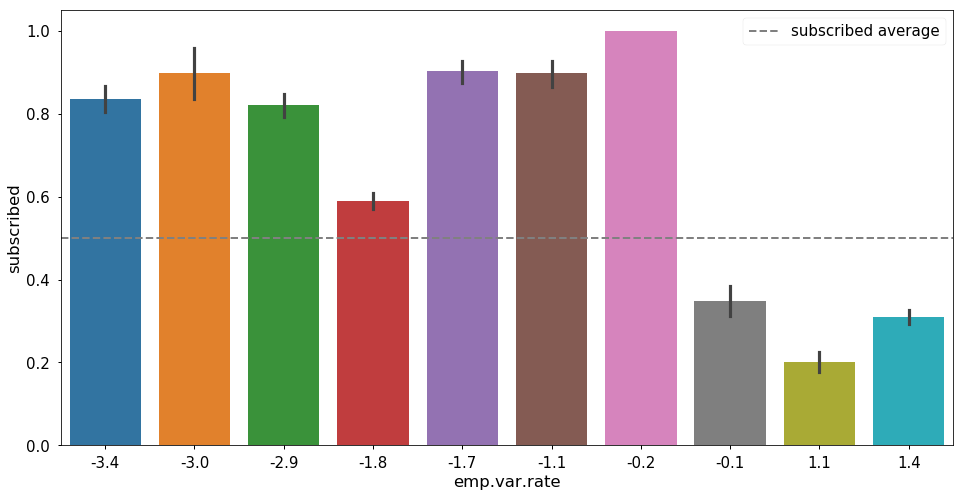

In [17]:
bar_plot_with_categorical(df, 'emp.var.rate', hue='subscribed',
                          order=np.sort(df['emp.var.rate'].unique()))

### month

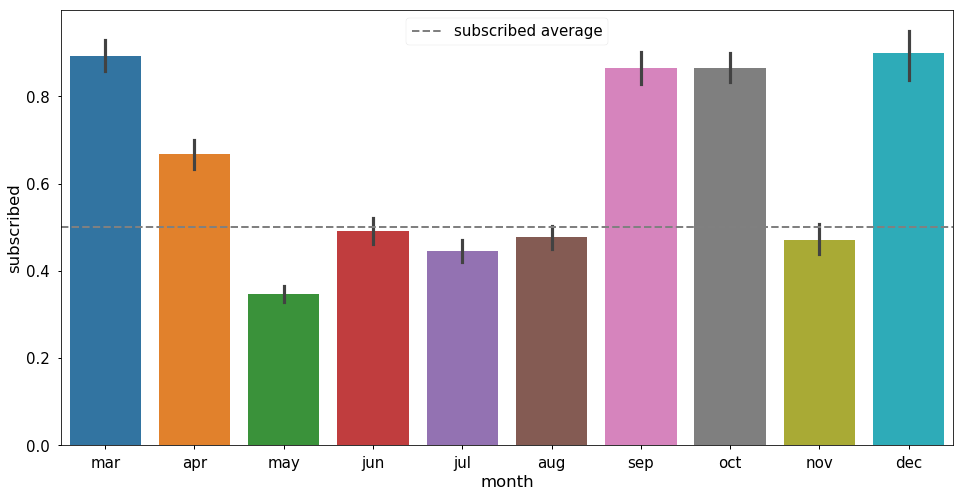

In [18]:
bar_plot_with_categorical(df, 'month', hue='subscribed',
                          order=['mar', 'apr', 'may', 'jun', 'jul', 
                                 'aug', 'sep', 'oct', 'nov', 'dec'])

### nr.employed

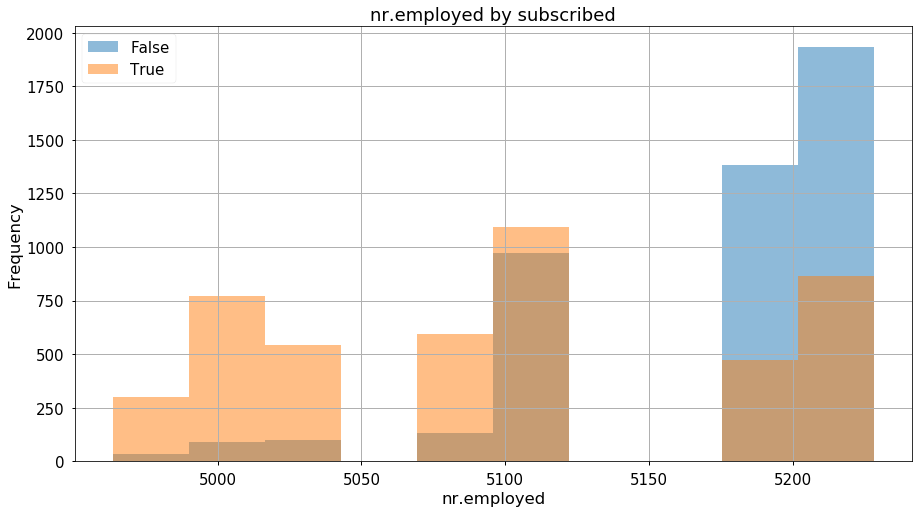

In [19]:
multiple_histograms_plot(df, x='nr.employed', hue='subscribed')

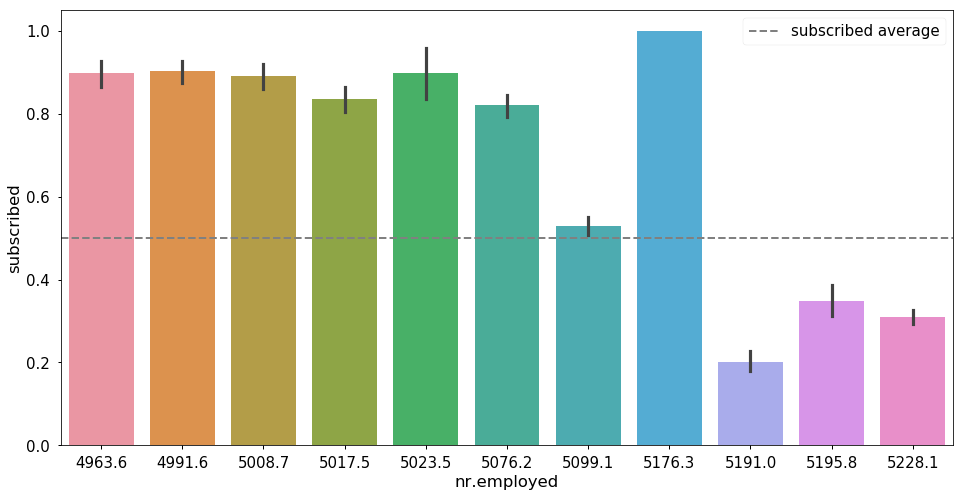

In [20]:
bar_plot_with_categorical(df, 'nr.employed', hue='subscribed',
                          figsize=(16, 8), order=np.sort(df['nr.employed'].unique()))

### euribor3m

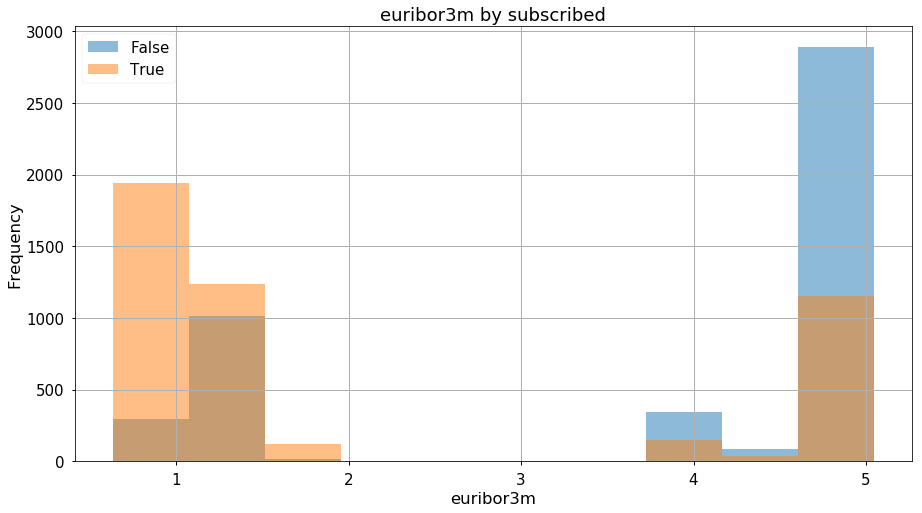

In [13]:
multiple_histograms_plot(df, x='euribor3m', hue='subscribed')

### contact

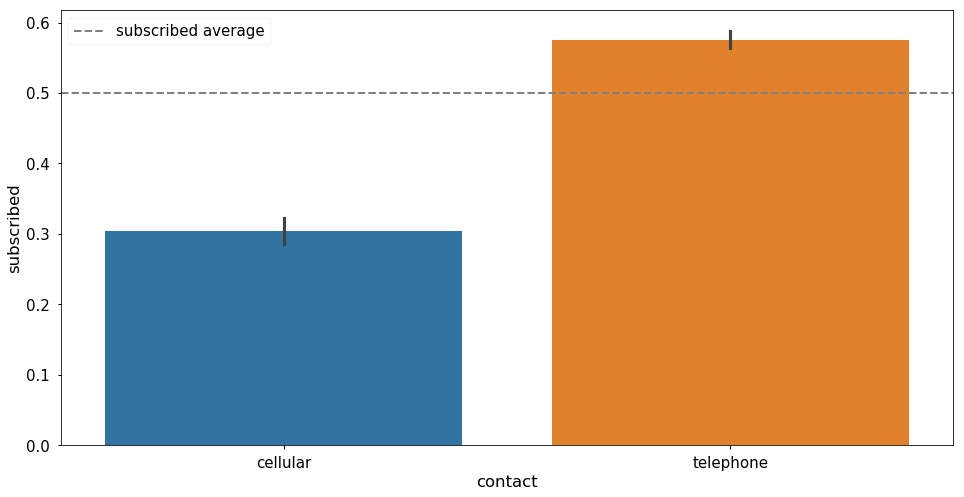

In [22]:
bar_plot_with_categorical(df, 'contact', hue='subscribed',
                          order=[1, 2], xticklabels=['cellular', 'telephone'])

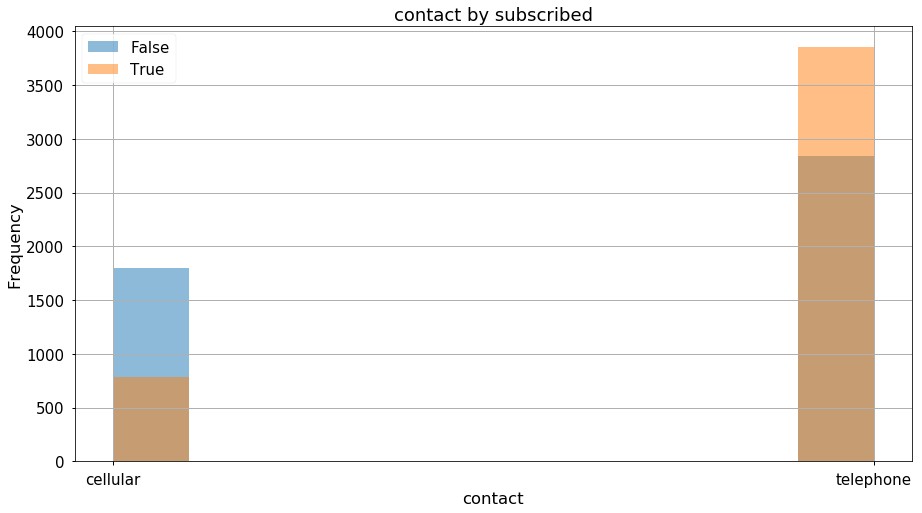

In [23]:
multiple_histograms_plot(df, x='contact', hue='subscribed',
                         xticks=[1, 2], xticklabels=['cellular', 'telephone'])

### loan

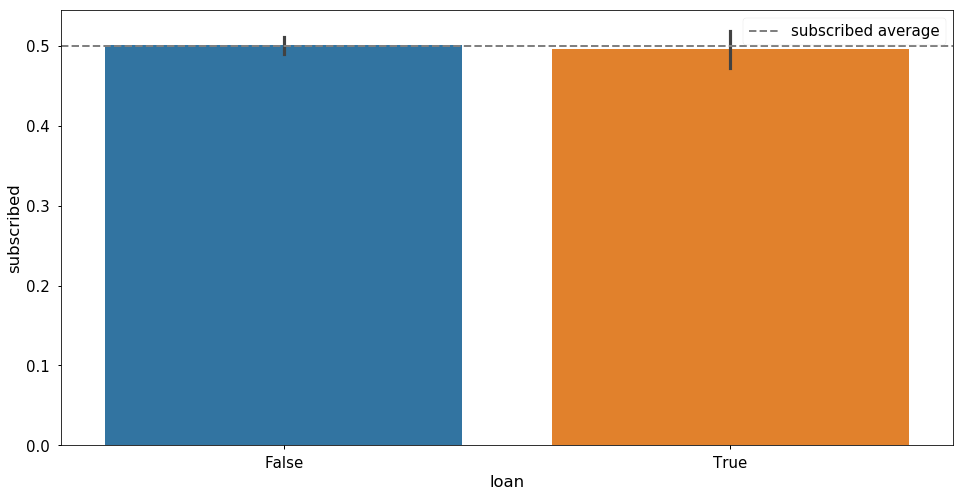

In [24]:
bar_plot_with_categorical(df, 'loan', hue='subscribed',
                          xticklabels=['False', 'True'])

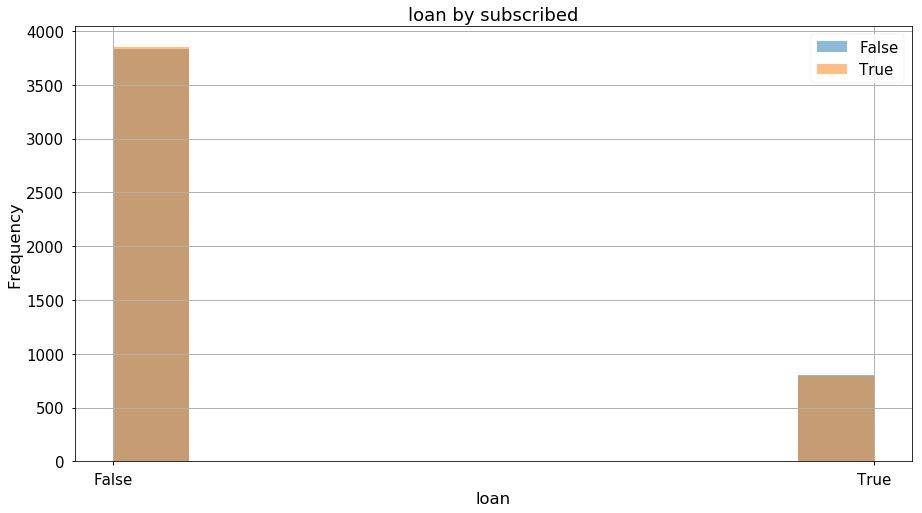

In [25]:
multiple_histograms_plot(df, x='loan', hue='subscribed',
                         xticks=[0, 1], xticklabels=['False', 'True'])

## Preparando os dados

In [ ]:
# crie a matriz 'X' sem log_duration_seconds, month e o target
<code>

# crie o vetor 'y' com o target
<code>

In [ ]:
# faça um train_test_split com 20% dos dados para teste
# para podermos comparar os resultados entre nós, vamos sempre usar random_state=0

X_train, X_test, y_train, y_test = <code>

## Aplicando a Regressão Logística

In [ ]:
logreg = LogisticRegression()

In [ ]:
# treine o modelo
<code>

# salve as predições do dataset de testes em 'y_pred'
<code>

In [ ]:
y_pred[:5]

In [ ]:
# imprima a acurácia
<code>

## Avaliação do modelo

### Matriz de Confusão, Precisão, Recall

In [ ]:
# imprima a matriz de confusao com a função 'confusion_matrix'
<code>

In [ ]:
plot_confusion_matrix(y_test, y_pred)

In [ ]:
# imprima precisão, recall e f1-score com a função 'classification_report'
<code>

### Utilizando as probabilidades

In [ ]:
# calcule as probabilidades de investimento com o método 'predict_proba'
# salve em 'y_pred_proba'
<code>

In [ ]:
y_pred_proba[:5]

In [ ]:
preds_df = pd.DataFrame(data=[y_pred_proba, y_test.astype(str)],
                        index=['Prediction', 'True Value']).T

preds_df['Prediction'] = preds_df['Prediction'].astype(float)
preds_df['True Value'] = preds_df['True Value'].astype(str)

preds_df.head()

In [ ]:
multiple_histograms_plot(data=preds_df, x='Prediction', hue='True Value',
                         bins=np.arange(0, 1.1, 0.025), probability_hist=True)

In [ ]:
# você gostaria de aumentar o recall ou a precisão?
# recalcule a matriz de confusão e o classification report com um threshold customizado
<code>

### Outras métricas populares

In [ ]:
# imprima o AUC com a função 'roc_auc_score'
<code>

In [ ]:
auc_test = plot_roc(y_test, y_pred_proba)

In [ ]:
# imprima o log loss com a função 'log_loss'
<code>

### Identificação de overfitting

In [ ]:
# calcule predições para o dataset de treino
<code>

In [ ]:
# imprima os AUCs de treino e de teste para comparação
<code>

## Tentando melhorar o modelo

Utilize algumas das seguintes técnicas para tentar melhorar o modelo:
    
1. one-hot-encoding para incluir a variável `month`
- tratamento de outliers em `duration_*`
- standardização dos dados
- remoção de features pouco importantes
- regularização com cross-validation

In [ ]:
<code>